In [1]:
%cd ~/REVIVAL2

/disk2/fli/REVIVAL2


In [2]:
%load_ext blackcellmagic

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# vis based on different metrics 
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

import warnings

from REVIVAL.analysis import ndcg, ndcg_scale, custom_ndcg, calc_top_n_percent_recall
from REVIVAL.util import get_file_name

# Suppress only ConstantInputWarning
warnings.simplefilter("ignore", category=UserWarning)


/disk2/fli/miniconda3/envs/REVIVAL/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [9]:
rmacbscope = pd.read_csv("/disk2/fli/REVIVAL2/zs/comb/Rma-CB_scope.csv")
rmacbscope

,AAs,var,fitness,selectivity,n_mut,enzyme,hd,enzyme_name,seq,substrate,...,pos,ev_score,esm_score,var_vol,substrate_vol,cofactor_vol,joint_vol,var-substrate_vol,var-cofactor_vol,var-joint_vol
0,YVMTMDTM,M100D,1850,76,1,Rma,-1,n.a.,TESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYCT...,NHC-borane,...,[100],-7.764500,-9.733734,183.502015,227.852385,1242.446898,1470.299283,-44.350370,-1058.944883,-1286.797268
1,YGMTMDTM,V75G:M100D,340,38,2,Rma,-2,BOR_G*,TESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYCT...,NHC-borane,...,"[75, 100]",-11.813801,-24.522847,303.146429,227.852385,1295.461835,1523.314220,75.294045,-992.315406,-1220.167791
2,YGFVLDLF,V75G:M89F:T98V:M99L:M100D:T101L:M103F,"1,120",80,7,Rma,-7,BOR_G1,TESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYCT...,NHC-borane,...,"[75, 89, 98, 99, 100, 101, 103]",-20.793549,-152.782623,30.881835,227.852385,1295.461835,1523.314220,-196.970550,-1264.580000,-1492.432385
3,YPMTMDTM,V75P:M100D,100,50,2,Rma,-2,BOR_P*,TESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYCT...,NHC-borane,...,"[75, 100]",-11.813801,-30.028481,162.922488,227.852385,1359.820988,1587.673373,-64.929896,-1196.898500,-1424.750885
4,YPMTMDTM,V75P:M100D,100,50,2,Rma,-2,BOR_P*,TESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYCT...,NHC-borane,...,"[75, 100]",-11.813801,-30.028481,162.922488,227.852385,1295.461835,1523.314220,-64.929896,-1132.539347,-1360.391732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,YRMTMDTT,V75R:M100D:M103T,2580,99,3,Rma,-3,BOR_R1,TESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYCT...,NHC-borane_5,...,"[75, 100, 103]",-14.183666,-43.323727,139.186989,227.852385,1207.390913,1435.243297,-88.665395,-1068.203923,-1296.056308
178,YRMTMDTT,V75R:M100D:M103T,2580,99,3,Rma,-3,BOR_R1,TESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYCT...,NHC-borane_5,...,"[75, 100, 103]",-14.183666,-43.323727,139.186989,227.852385,1277.502883,1505.355268,-88.665395,-1138.315894,-1366.168279
179,YRMTMDTT,V75R:M100D:M103T,2580,99,3,Rma,-3,BOR_R1,TESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYCT...,NHC-borane_5,...,"[75, 100, 103]",-14.183666,-43.323727,139.186989,227.852385,1359.820988,1587.673373,-88.665395,-1220.633999,-1448.486384
180,YVMTMMTM,WT,120,70,0,Rma,0,BOR_WT,TESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYCT...,NHC-borane,...,[],0.000000,0.000000,138.961000,227.852385,1242.446898,1470.299283,-88.891385,-1103.485898,-1331.338283


In [15]:
fit_rho_list = []
fit_ndcg_list = []
fit_top10_list = []
fit_top25_list = []
fit_top50_list = []

sele_rho_list = []
sele_ndcg_list = []
sele_top10_list = []
sele_top25_list = []
sele_top50_list = []

for f in glob("/disk2/fli/REVIVAL2/zs/comb/*.csv"):
    df_original = pd.read_csv(f)
    # see if the fitness is a string
    if df_original["fitness"].dtype == "O":
        # convert fitness to numerical
        df_original["fitness"] = pd.to_numeric(df_original["fitness"].str.replace(",", ""), errors='coerce')
    df_original = df_original[df_original.select_dtypes(include=["number"]).columns]
    df_name = get_file_name(f)
    print(df_name)

    rho_dict = {"lib": df_name}
    ndcg_dict = {"lib": df_name}
    top10_dict = {"lib": df_name}
    top25_dict = {"lib": df_name}
    top50_dict = {"lib": df_name}

    if "selectivity" in df_original.columns:
        add_selectivity = True
        sele_rho_dict = {"lib": df_name}
        sele_ndcg_dict = {"lib": df_name}
        sele_top10_dict = {"lib": df_name}
        sele_top25_dict = {"lib": df_name}
        sele_top50_dict = {"lib": df_name}
    else:
        add_selectivity = False

    for c in df_original.columns:
        if c == "fitness" or "_rank" in c:
            continue
        # check if nan is in the column, if so print out the rows with nan
        # if df_original[c].isna().sum() > 0:
            # print(c)
            # print(len(df_original[df_original[c].isna()]))
        # now slice out the rows without nan
        df = df_original[df_original[c].notna()]
        if len(df) == 0:
            rho_dict[c] = np.nan
            ndcg_dict[c] = np.nan
            top10_dict[c] = np.nan
            top25_dict[c] = np.nan
            top50_dict[c] = np.nan

            if add_selectivity:
                sele_rho_dict[c] = np.nan
                sele_ndcg_dict[c] = np.nan
                sele_top10_dict[c] = np.nan
                sele_top25_dict[c] = np.nan
                sele_top50_dict[c] = np.nan

        else:

            y_true = df["fitness"].values
            y_score = df[c].values

            if (
                "Triad_score" in c
                or "chain_pae_min" in c
                or "sum_" in c
                or "naive_score" in c
                or c == "complexscore"
                or c == "dH"
                or c == "ligscore"
                or c == "recscore"
                or c == "score"
                or c == "total_score"
                or "vina_" in c
                or "0:" in c
                or "1:" in c
                or "2:" in c
            ):
                y_score = -1 * y_score
                # print(f"flipping {c}")
            if " - " in c:
                y_score = np.abs(y_score)
            if np.all(y_score == y_score[0]):  # Check if all values are identical
                rho_dict[c] = np.nan  # Assign NaN or 0 if needed
            else:
                rho_dict[c] = spearmanr(y_true, y_score).correlation
            ndcg_dict[c] = ndcg_scale(y_true=y_true, y_pred=y_score)
            top10_dict[c] = calc_top_n_percent_recall(
                y_true=y_true, y_score=y_score, top_n=10
            )
            top25_dict[c] = calc_top_n_percent_recall(
                y_true=y_true, y_score=y_score, top_n=25
            )
            top50_dict[c] = calc_top_n_percent_recall(
                y_true=y_true, y_score=y_score, top_n=50
            )

            if add_selectivity and c != "selectivity":
                y_true_sele = df["selectivity"].values
                y_score_sele = y_score

                if np.all(
                    y_score_sele == y_score_sele[0]
                ):  # Check if all values are identical
                    sele_rho_dict[c] = np.nan
                else:
                    sele_rho_dict[c] = spearmanr(y_true_sele, y_score_sele).correlation
                sele_ndcg_dict[c] = ndcg_scale(y_true=y_true_sele, y_pred=y_score_sele)
                sele_top10_dict[c] = calc_top_n_percent_recall(
                    y_true=y_true_sele, y_score=y_score_sele, top_n=10
                )
                sele_top25_dict[c] = calc_top_n_percent_recall(
                    y_true=y_true_sele, y_score=y_score_sele, top_n=25
                )
                sele_top50_dict[c] = calc_top_n_percent_recall(
                    y_true=y_true_sele, y_score=y_score_sele, top_n=50
                )

    fit_rho_list.append(rho_dict)
    fit_ndcg_list.append(ndcg_dict)
    fit_top10_list.append(top10_dict)
    fit_top25_list.append(top25_dict)
    fit_top50_list.append(top50_dict)

    if add_selectivity:
        sele_rho_list.append(sele_rho_dict)
        sele_ndcg_list.append(sele_ndcg_dict)
        sele_top10_list.append(sele_top10_dict)
        sele_top25_list.append(sele_top25_dict)
        sele_top50_list.append(sele_top50_dict)

df_rho_fit = pd.DataFrame(fit_rho_list)
df_ndcg_fit = pd.DataFrame(fit_ndcg_list)
df_top10_fit = pd.DataFrame(fit_top10_list)
df_top25_fit = pd.DataFrame(fit_top25_list)
df_top50_fit = pd.DataFrame(fit_top50_list)
df_rho_sele = pd.DataFrame(sele_rho_list)
df_ndcg_sele = pd.DataFrame(sele_ndcg_list)
df_top10_sele = pd.DataFrame(sele_top10_list)
df_top25_sele = pd.DataFrame(sele_top25_list)
df_top50_sele = pd.DataFrame(sele_top50_list)

ParLQ
PfTrpB-5iodo
PfTrpB-5bromo
PfTrpB-5cyano
ParLQ-c
ParLQ-g
PfTrpB-56chloro
ParLQ-i
ParLQ-d
PfTrpB-6chloro
ParLQ-f
Rma-CSi_scope
Rma-CB
ParLQ-b
Rma-CSi
Rma-CB_scope
PfTrpB-4cyano
PfTrpB-4bromo
PfTrpB_scope
ParLQ-e
PfTrpB-7iodo
PfTrpB-7methyl
PfTrpB-7bromo
ParLQ-h
PfTrpB-5chloro


In [ ]:
for c in df_rho_fit.columns:
    if "std" not in c:
        print(c)

In [16]:
custom_order = [
    "PfTrpB-7iodo",
    "PfTrpB-7methyl",
    "PfTrpB-7bromo",
    "PfTrpB-5iodo",
    "PfTrpB-5bromo",
    "PfTrpB-5chloro",
    "PfTrpB-4bromo",
    "PfTrpB-6chloro",
    "PfTrpB-5cyano",
    "PfTrpB-4cyano",
    "PfTrpB-56chloro",
    "Rma-CB",
    "Rma-CSi",
    "ParLQ",
    "ParLQ-b",
    "ParLQ-c",
    "ParLQ-d",
    "ParLQ-e",
    "ParLQ-f",
    "ParLQ-g",
    "ParLQ-h",
    "ParLQ-i",
]
# substrate
# 7iodo       0.605263
# 7methyl     0.605263
# 7bromo      0.605263
# 5iodo       0.600000
# 5bromo      0.600000
# 5chloro     0.600000
# 4bromo      0.550000
# 6chloro     0.536585
# 5cyano      0.489796
# 4cyano      0.489362
# 56chloro    0.333333
# Name: Atom Pair, dtype: float64

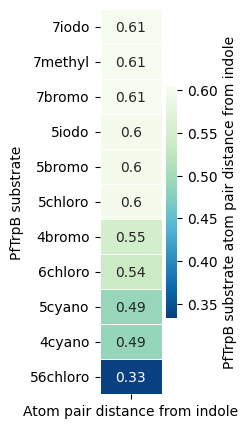

In [22]:

# Sample data
data = {
    "PfTrpB substrate": [
        "7iodo", "7methyl", "7bromo", "5iodo", "5bromo",
        "5chloro", "4bromo", "6chloro", "5cyano", "4cyano", "56chloro"
    ],
    "Atom pair distance from indole": [
        0.605263, 0.605263, 0.605263, 0.600000, 0.600000,
        0.600000, 0.550000, 0.536585, 0.489796, 0.489362, 0.333333
    ]
}

# Convert to DataFrame
df = pd.DataFrame(data).set_index("PfTrpB substrate")

# Set figure size
plt.figure(figsize=(1, 5))

# Create heatmap with grayscale colormap
sns.heatmap(df, cmap="GnBu_r", annot=True, linewidths=0.5, cbar_kws={"label": "PfTrpB substrate atom pair distance from indole"}  )

# Show plot
plt.show()


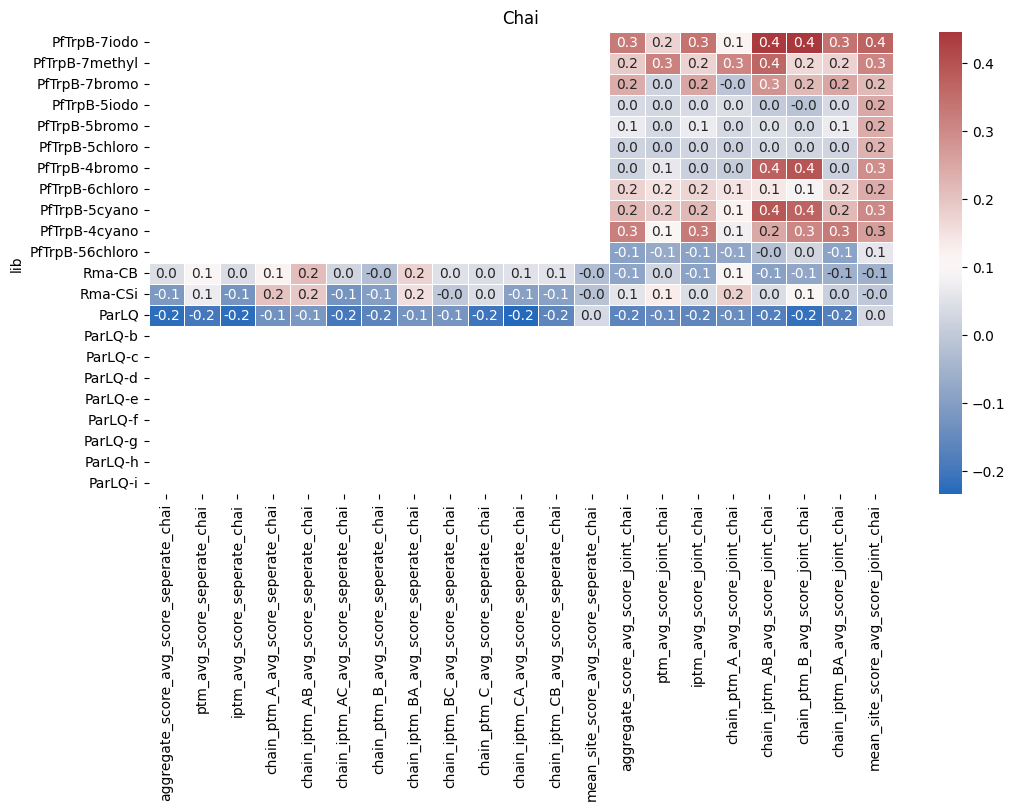

In [17]:
chai_df = (
    df_rho_fit[
        [
            "lib",
            "aggregate_score_avg_score_seperate_chai",
            "ptm_avg_score_seperate_chai",
            "iptm_avg_score_seperate_chai",
            "chain_ptm_A_avg_score_seperate_chai",
            "chain_iptm_AB_avg_score_seperate_chai",
            "chain_iptm_AC_avg_score_seperate_chai",
            "chain_ptm_B_avg_score_seperate_chai",
            "chain_iptm_BA_avg_score_seperate_chai",
            "chain_iptm_BC_avg_score_seperate_chai",
            "chain_ptm_C_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CB_avg_score_seperate_chai",
            "mean_site_score_avg_score_seperate_chai",
            "aggregate_score_avg_score_joint_chai",
            "ptm_avg_score_joint_chai",
            "iptm_avg_score_joint_chai",
            "chain_ptm_A_avg_score_joint_chai",
            "chain_iptm_AB_avg_score_joint_chai",
            "chain_ptm_B_avg_score_joint_chai",
            "chain_iptm_BA_avg_score_joint_chai",
            "mean_site_score_avg_score_joint_chai",
        ]
    ]
    .set_index("lib")
    .reindex(custom_order)
)

# Set the figure size
plt.figure(figsize=(12, 6))

# Create a heatmap
sns.heatmap(chai_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)

# Show the plot
plt.title("Chai")
plt.show()

In [15]:
chai_df.mean().sort_values(ascending=False)

mean_site_score_avg_score_joint_chai       0.195523
chain_iptm_AB_avg_score_joint_chai         0.147932
chain_ptm_B_avg_score_joint_chai           0.133046
chain_iptm_AB_avg_score_seperate_chai      0.095471
aggregate_score_avg_score_joint_chai       0.095056
iptm_avg_score_joint_chai                  0.094393
chain_iptm_BA_avg_score_joint_chai         0.093071
ptm_avg_score_joint_chai                   0.072293
chain_iptm_BA_avg_score_seperate_chai      0.067171
chain_ptm_A_avg_score_joint_chai           0.065338
chain_ptm_A_avg_score_seperate_chai        0.063746
mean_site_score_avg_score_seperate_chai   -0.003843
ptm_avg_score_seperate_chai               -0.009529
chain_iptm_BC_avg_score_seperate_chai     -0.027076
chain_ptm_C_avg_score_seperate_chai       -0.040655
chain_iptm_CB_avg_score_seperate_chai     -0.067363
chain_iptm_CA_avg_score_seperate_chai     -0.093518
chain_ptm_B_avg_score_seperate_chai       -0.098036
aggregate_score_avg_score_seperate_chai   -0.098568
chain_iptm_A

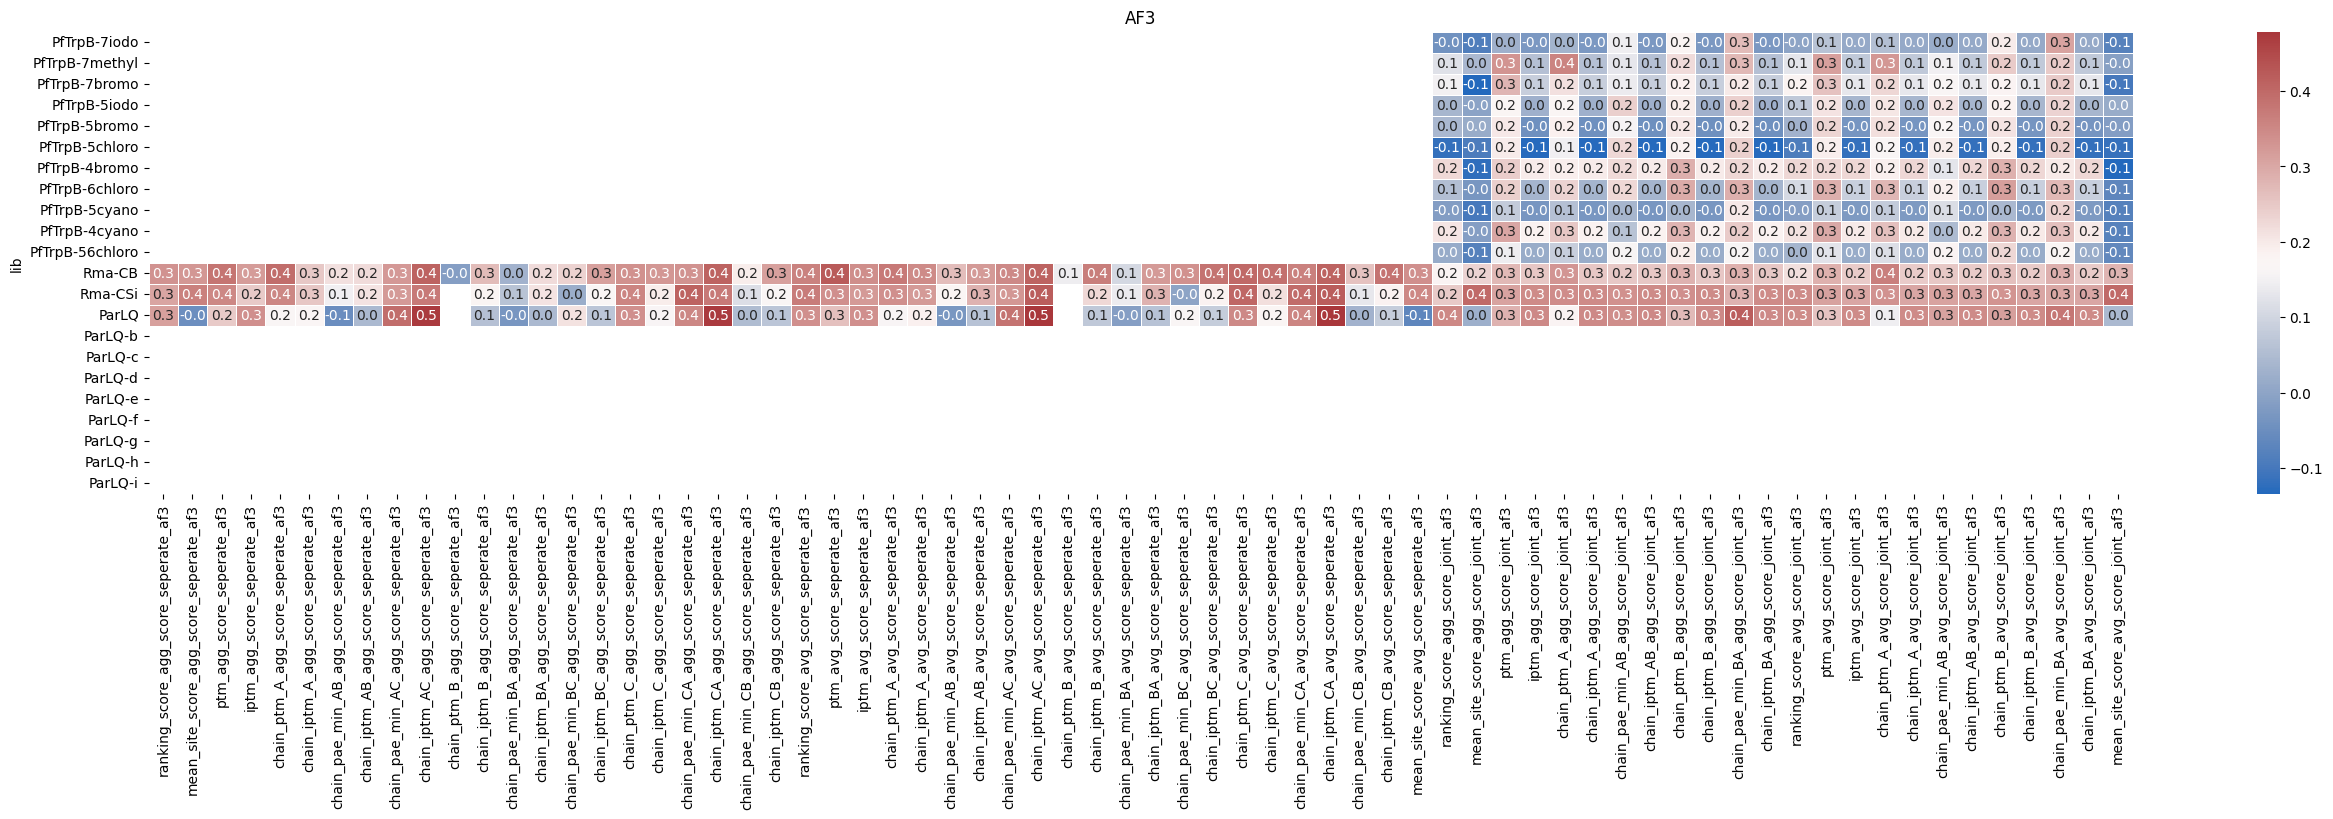

In [18]:
af3_df = (
    df_rho_fit[
        [
            "lib",
            "ranking_score_agg_score_seperate_af3",
            "mean_site_score_agg_score_seperate_af3",
            "ptm_agg_score_seperate_af3",
            "iptm_agg_score_seperate_af3",
            # "fraction_disordered_agg_score_seperate_af3",
            "chain_ptm_A_agg_score_seperate_af3",
            "chain_iptm_A_agg_score_seperate_af3",
            "chain_pae_min_AB_agg_score_seperate_af3",
            "chain_iptm_AB_agg_score_seperate_af3",
            "chain_pae_min_AC_agg_score_seperate_af3",
            "chain_iptm_AC_agg_score_seperate_af3",
            "chain_ptm_B_agg_score_seperate_af3",
            "chain_iptm_B_agg_score_seperate_af3",
            "chain_pae_min_BA_agg_score_seperate_af3",
            "chain_iptm_BA_agg_score_seperate_af3",
            "chain_pae_min_BC_agg_score_seperate_af3",
            "chain_iptm_BC_agg_score_seperate_af3",
            "chain_ptm_C_agg_score_seperate_af3",
            "chain_iptm_C_agg_score_seperate_af3",
            "chain_pae_min_CA_agg_score_seperate_af3",
            "chain_iptm_CA_agg_score_seperate_af3",
            "chain_pae_min_CB_agg_score_seperate_af3",
            "chain_iptm_CB_agg_score_seperate_af3",
            "ranking_score_avg_score_seperate_af3",
            "ptm_avg_score_seperate_af3",
            "iptm_avg_score_seperate_af3",
            # "fraction_disordered_avg_score_seperate_af3",
            "chain_ptm_A_avg_score_seperate_af3",
            "chain_iptm_A_avg_score_seperate_af3",
            "chain_pae_min_AB_avg_score_seperate_af3",
            "chain_iptm_AB_avg_score_seperate_af3",
            "chain_pae_min_AC_avg_score_seperate_af3",
            "chain_iptm_AC_avg_score_seperate_af3",
            "chain_ptm_B_avg_score_seperate_af3",
            "chain_iptm_B_avg_score_seperate_af3",
            "chain_pae_min_BA_avg_score_seperate_af3",
            "chain_iptm_BA_avg_score_seperate_af3",
            "chain_pae_min_BC_avg_score_seperate_af3",
            "chain_iptm_BC_avg_score_seperate_af3",
            "chain_ptm_C_avg_score_seperate_af3",
            "chain_iptm_C_avg_score_seperate_af3",
            "chain_pae_min_CA_avg_score_seperate_af3",
            "chain_iptm_CA_avg_score_seperate_af3",
            "chain_pae_min_CB_avg_score_seperate_af3",
            "chain_iptm_CB_avg_score_seperate_af3",
            "mean_site_score_avg_score_seperate_af3",
            "ranking_score_agg_score_joint_af3",
            "mean_site_score_agg_score_joint_af3",
            "ptm_agg_score_joint_af3",
            "iptm_agg_score_joint_af3",
            # "fraction_disordered_agg_score_joint_af3",
            "chain_ptm_A_agg_score_joint_af3",
            "chain_iptm_A_agg_score_joint_af3",
            "chain_pae_min_AB_agg_score_joint_af3",
            "chain_iptm_AB_agg_score_joint_af3",
            "chain_ptm_B_agg_score_joint_af3",
            "chain_iptm_B_agg_score_joint_af3",
            "chain_pae_min_BA_agg_score_joint_af3",
            "chain_iptm_BA_agg_score_joint_af3",
            "ranking_score_avg_score_joint_af3",
            "ptm_avg_score_joint_af3",
            "iptm_avg_score_joint_af3",
            # "fraction_disordered_avg_score_joint_af3",
            "chain_ptm_A_avg_score_joint_af3",
            "chain_iptm_A_avg_score_joint_af3",
            "chain_pae_min_AB_avg_score_joint_af3",
            "chain_iptm_AB_avg_score_joint_af3",
            "chain_ptm_B_avg_score_joint_af3",
            "chain_iptm_B_avg_score_joint_af3",
            "chain_pae_min_BA_avg_score_joint_af3",
            "chain_iptm_BA_avg_score_joint_af3",
            "mean_site_score_avg_score_joint_af3",
        ]
    ]
    .set_index("lib")
    .reindex(custom_order)
)

# Set the figure size
plt.figure(figsize=(32, 6))

# Create a heatmap
sns.heatmap(af3_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)

# Show the plot
plt.title("AF3")
plt.show()

In [17]:
af3_df.mean().sort_values(ascending=False)[:18]

chain_iptm_AC_avg_score_seperate_af3       0.436514
chain_iptm_CA_avg_score_seperate_af3       0.436514
chain_iptm_AC_agg_score_seperate_af3       0.418810
chain_iptm_CA_agg_score_seperate_af3       0.418810
chain_ptm_C_avg_score_seperate_af3         0.383702
chain_pae_min_CA_avg_score_seperate_af3    0.372001
chain_pae_min_CA_agg_score_seperate_af3    0.366229
ranking_score_avg_score_seperate_af3       0.355507
chain_pae_min_AC_avg_score_seperate_af3    0.353640
chain_pae_min_AC_agg_score_seperate_af3    0.346240
chain_ptm_C_agg_score_seperate_af3         0.343325
ptm_avg_score_seperate_af3                 0.341455
iptm_avg_score_seperate_af3                0.333925
ptm_agg_score_seperate_af3                 0.326257
ranking_score_agg_score_seperate_af3       0.316750
chain_ptm_A_agg_score_seperate_af3         0.304504
iptm_agg_score_seperate_af3                0.301812
chain_ptm_A_avg_score_seperate_af3         0.292070
dtype: float64

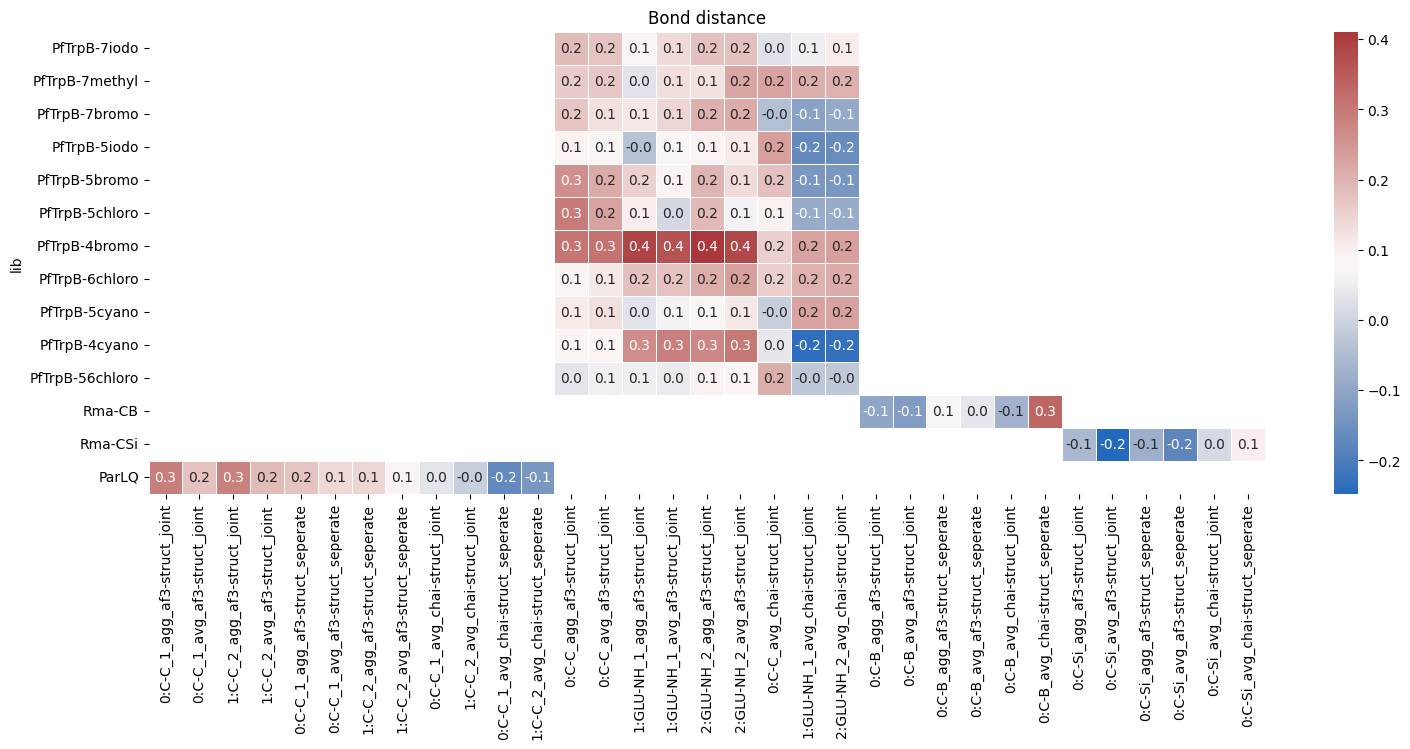

In [80]:
bond_df = (
    df_rho_fit[
        [
            "lib",
            "0:C-C_1_agg_af3-struct_joint",
            "0:C-C_1_avg_af3-struct_joint",
            "1:C-C_2_agg_af3-struct_joint",
            "1:C-C_2_avg_af3-struct_joint",
            "0:C-C_1_agg_af3-struct_seperate",
            "0:C-C_1_avg_af3-struct_seperate",
            "1:C-C_2_agg_af3-struct_seperate",
            "1:C-C_2_avg_af3-struct_seperate",
            "0:C-C_1_avg_chai-struct_joint",
            "1:C-C_2_avg_chai-struct_joint",
            "0:C-C_1_avg_chai-struct_seperate",
            "1:C-C_2_avg_chai-struct_seperate",
            "0:C-C_agg_af3-struct_joint",
            "0:C-C_avg_af3-struct_joint",
            "1:GLU-NH_1_agg_af3-struct_joint",
            "1:GLU-NH_1_avg_af3-struct_joint",
            "2:GLU-NH_2_agg_af3-struct_joint",
            "2:GLU-NH_2_avg_af3-struct_joint",
            "0:C-C_avg_chai-struct_joint",
            "1:GLU-NH_1_avg_chai-struct_joint",
            "2:GLU-NH_2_avg_chai-struct_joint",
            "0:C-B_agg_af3-struct_joint",
            "0:C-B_avg_af3-struct_joint",
            "0:C-B_agg_af3-struct_seperate",
            "0:C-B_avg_af3-struct_seperate",
            "0:C-B_avg_chai-struct_joint",
            "0:C-B_avg_chai-struct_seperate",
            "0:C-Si_agg_af3-struct_joint",
            "0:C-Si_avg_af3-struct_joint",
            "0:C-Si_agg_af3-struct_seperate",
            "0:C-Si_avg_af3-struct_seperate",
            "0:C-Si_avg_chai-struct_joint",
            "0:C-Si_avg_chai-struct_seperate",
        ]
    ]
    .set_index("lib")
    .reindex(custom_order)
)

# Set the figure size
plt.figure(figsize=(18, 6))

# Create a heatmap
sns.heatmap(bond_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)

# Show the plot
plt.title("Bond distance")
plt.show()

In [83]:
bond_df.mean().sort_values(ascending=False)[:10]

0:C-B_avg_chai-struct_seperate     0.333174
0:C-C_1_agg_af3-struct_joint       0.292502
1:C-C_2_agg_af3-struct_joint       0.282574
2:GLU-NH_2_agg_af3-struct_joint    0.187464
2:GLU-NH_2_avg_af3-struct_joint    0.185313
1:C-C_2_avg_af3-struct_joint       0.185062
0:C-C_1_avg_af3-struct_joint       0.176340
0:C-C_1_agg_af3-struct_seperate    0.173379
0:C-C_agg_af3-struct_joint         0.162838
0:C-C_avg_af3-struct_joint         0.152101
dtype: float64

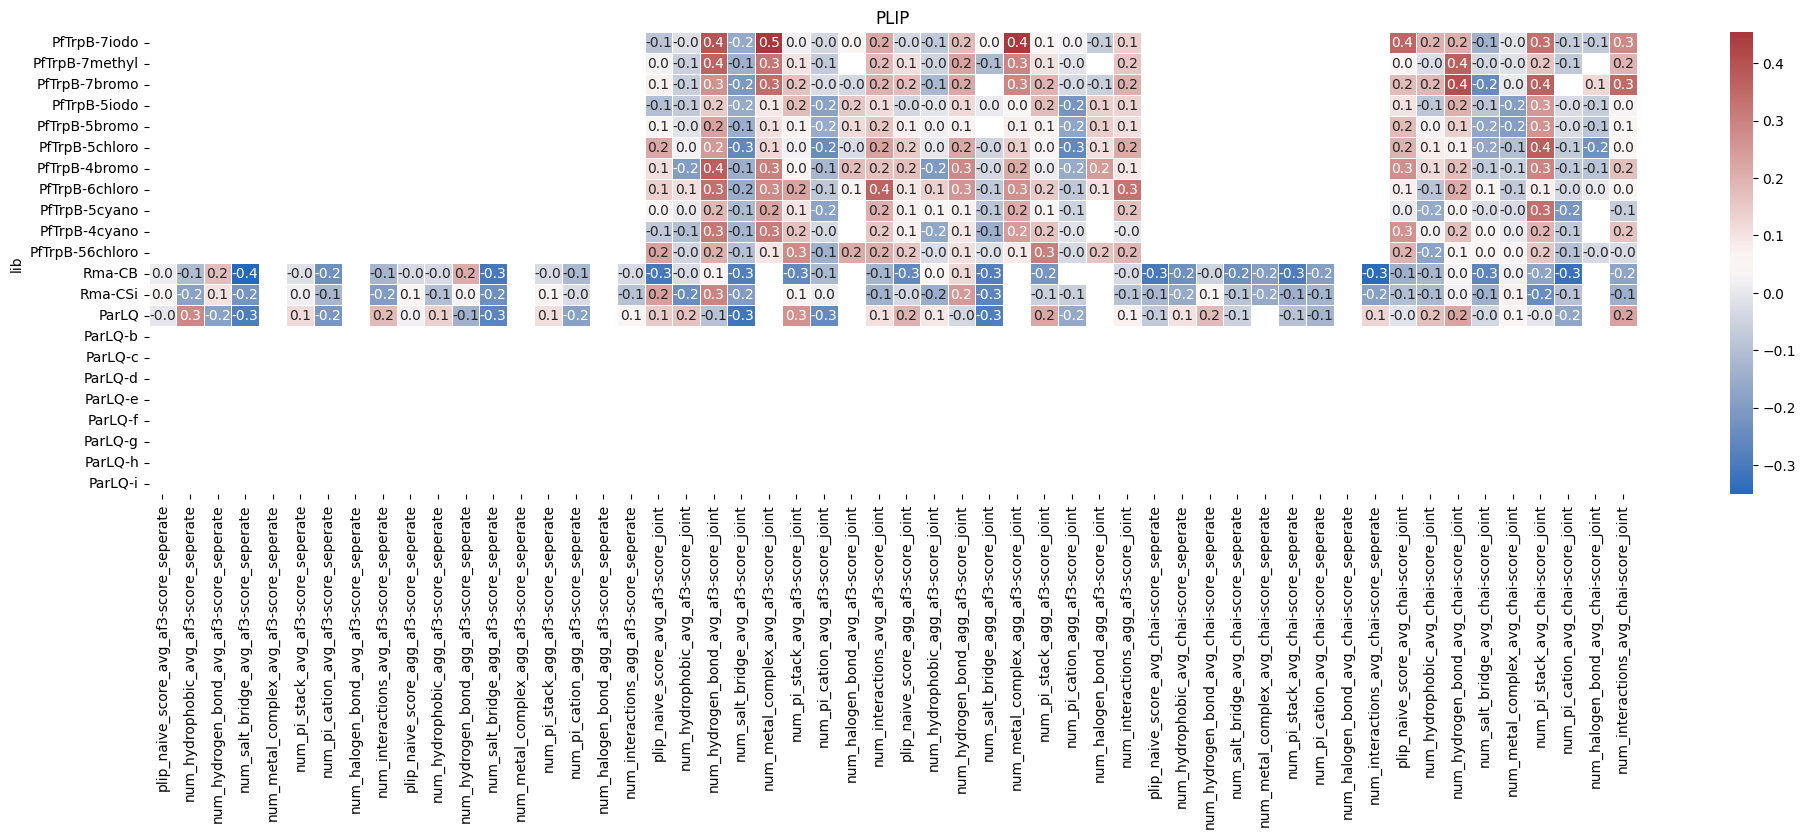

In [19]:
plip_metrics = [
    "lib",
    "plip_naive_score_avg_af3-score_seperate",
    "num_hydrophobic_avg_af3-score_seperate",
    # "sum_hydrophobic_avg_af3-score_seperate",
    "num_hydrogen_bond_avg_af3-score_seperate",
    # "sum_hydrogen_bond_avg_af3-score_seperate",
    "num_salt_bridge_avg_af3-score_seperate",
    # "sum_salt_bridge_avg_af3-score_seperate",
    "num_metal_complex_avg_af3-score_seperate",
    # "sum_metal_complex_avg_af3-score_seperate",
    "num_pi_stack_avg_af3-score_seperate",
    # "sum_pi_stack_avg_af3-score_seperate",
    "num_pi_cation_avg_af3-score_seperate",
    # "sum_pi_cation_avg_af3-score_seperate",
    "num_halogen_bond_avg_af3-score_seperate",
    # "sum_halogen_bond_avg_af3-score_seperate",
    "num_interactions_avg_af3-score_seperate",
    "plip_naive_score_agg_af3-score_seperate",
    "num_hydrophobic_agg_af3-score_seperate",
    # "sum_hydrophobic_agg_af3-score_seperate",
    "num_hydrogen_bond_agg_af3-score_seperate",
    # "sum_hydrogen_bond_agg_af3-score_seperate",
    "num_salt_bridge_agg_af3-score_seperate",
    # "sum_salt_bridge_agg_af3-score_seperate",
    "num_metal_complex_agg_af3-score_seperate",
    # "sum_metal_complex_agg_af3-score_seperate",
    "num_pi_stack_agg_af3-score_seperate",
    # "sum_pi_stack_agg_af3-score_seperate",
    "num_pi_cation_agg_af3-score_seperate",
    # "sum_pi_cation_agg_af3-score_seperate",
    "num_halogen_bond_agg_af3-score_seperate",
    # "sum_halogen_bond_agg_af3-score_seperate",
    "num_interactions_agg_af3-score_seperate",
    "plip_naive_score_avg_af3-score_joint",
    "num_hydrophobic_avg_af3-score_joint",
    # "sum_hydrophobic_avg_af3-score_joint",
    "num_hydrogen_bond_avg_af3-score_joint",
    # "sum_hydrogen_bond_avg_af3-score_joint",
    "num_salt_bridge_avg_af3-score_joint",
    # "sum_salt_bridge_avg_af3-score_joint",
    "num_metal_complex_avg_af3-score_joint",
    # "sum_metal_complex_avg_af3-score_joint",
    "num_pi_stack_avg_af3-score_joint",
    # "sum_pi_stack_avg_af3-score_joint",
    "num_pi_cation_avg_af3-score_joint",
    # "sum_pi_cation_avg_af3-score_joint",
    "num_halogen_bond_avg_af3-score_joint",
    # "sum_halogen_bond_avg_af3-score_joint",
    "num_interactions_avg_af3-score_joint",
    "plip_naive_score_agg_af3-score_joint",
    "num_hydrophobic_agg_af3-score_joint",
    # "sum_hydrophobic_agg_af3-score_joint",
    "num_hydrogen_bond_agg_af3-score_joint",
    # "sum_hydrogen_bond_agg_af3-score_joint",
    "num_salt_bridge_agg_af3-score_joint",
    # "sum_salt_bridge_agg_af3-score_joint",
    "num_metal_complex_agg_af3-score_joint",
    # "sum_metal_complex_agg_af3-score_joint",
    "num_pi_stack_agg_af3-score_joint",
    # "sum_pi_stack_agg_af3-score_joint",
    "num_pi_cation_agg_af3-score_joint",
    # "sum_pi_cation_agg_af3-score_joint",
    "num_halogen_bond_agg_af3-score_joint",
    # "sum_halogen_bond_agg_af3-score_joint",
    "num_interactions_agg_af3-score_joint",
    "plip_naive_score_avg_chai-score_seperate",
    "num_hydrophobic_avg_chai-score_seperate",
    # "sum_hydrophobic_avg_chai-score_seperate",
    "num_hydrogen_bond_avg_chai-score_seperate",
    # "sum_hydrogen_bond_avg_chai-score_seperate",
    "num_salt_bridge_avg_chai-score_seperate",
    # "sum_salt_bridge_avg_chai-score_seperate",
    "num_metal_complex_avg_chai-score_seperate",
    # "sum_metal_complex_avg_chai-score_seperate",
    "num_pi_stack_avg_chai-score_seperate",
    # "sum_pi_stack_avg_chai-score_seperate",
    "num_pi_cation_avg_chai-score_seperate",
    # "sum_pi_cation_avg_chai-score_seperate",
    "num_halogen_bond_avg_chai-score_seperate",
    # "sum_halogen_bond_avg_chai-score_seperate",
    "num_interactions_avg_chai-score_seperate",
    "plip_naive_score_avg_chai-score_joint",
    "num_hydrophobic_avg_chai-score_joint",
    # "sum_hydrophobic_avg_chai-score_joint",
    "num_hydrogen_bond_avg_chai-score_joint",
    # "sum_hydrogen_bond_avg_chai-score_joint",
    "num_salt_bridge_avg_chai-score_joint",
    # "sum_salt_bridge_avg_chai-score_joint",
    "num_metal_complex_avg_chai-score_joint",
    # "sum_metal_complex_avg_chai-score_joint",
    "num_pi_stack_avg_chai-score_joint",
    # "sum_pi_stack_avg_chai-score_joint",
    "num_pi_cation_avg_chai-score_joint",
    # "sum_pi_cation_avg_chai-score_joint",
    "num_halogen_bond_avg_chai-score_joint",
    # "sum_halogen_bond_avg_chai-score_joint",
    "num_interactions_avg_chai-score_joint"
]

plip_df = df_rho_fit[plip_metrics].set_index("lib").reindex(custom_order)

# Set the figure size
plt.figure(figsize=(24, 6))

# Create a heatmap
sns.heatmap(plip_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)

# Show the plot
plt.title("PLIP")
plt.show()

In [25]:
plip_df.mean().sort_values(ascending=False)[:16]

num_metal_complex_avg_af3-score_joint        0.242016
num_hydrogen_bond_avg_af3-score_joint        0.238973
num_metal_complex_agg_af3-score_joint        0.210913
num_pi_stack_avg_chai-score_joint            0.171691
num_hydrogen_bond_avg_chai-score_joint       0.167127
num_hydrogen_bond_agg_af3-score_joint        0.156176
num_interactions_avg_af3-score_joint         0.146445
num_interactions_agg_af3-score_joint         0.120545
plip_naive_score_avg_chai-score_joint        0.115248
num_pi_stack_avg_af3-score_joint             0.103638
num_halogen_bond_agg_af3-score_joint         0.097520
num_pi_stack_agg_af3-score_joint             0.090524
num_halogen_bond_avg_af3-score_joint         0.089009
num_interactions_avg_chai-score_joint        0.083275
plip_naive_score_agg_af3-score_joint         0.065372
num_hydrogen_bond_avg_chai-score_seperate    0.063089
dtype: float64

Text(0.5, 1.0, 'Vina')

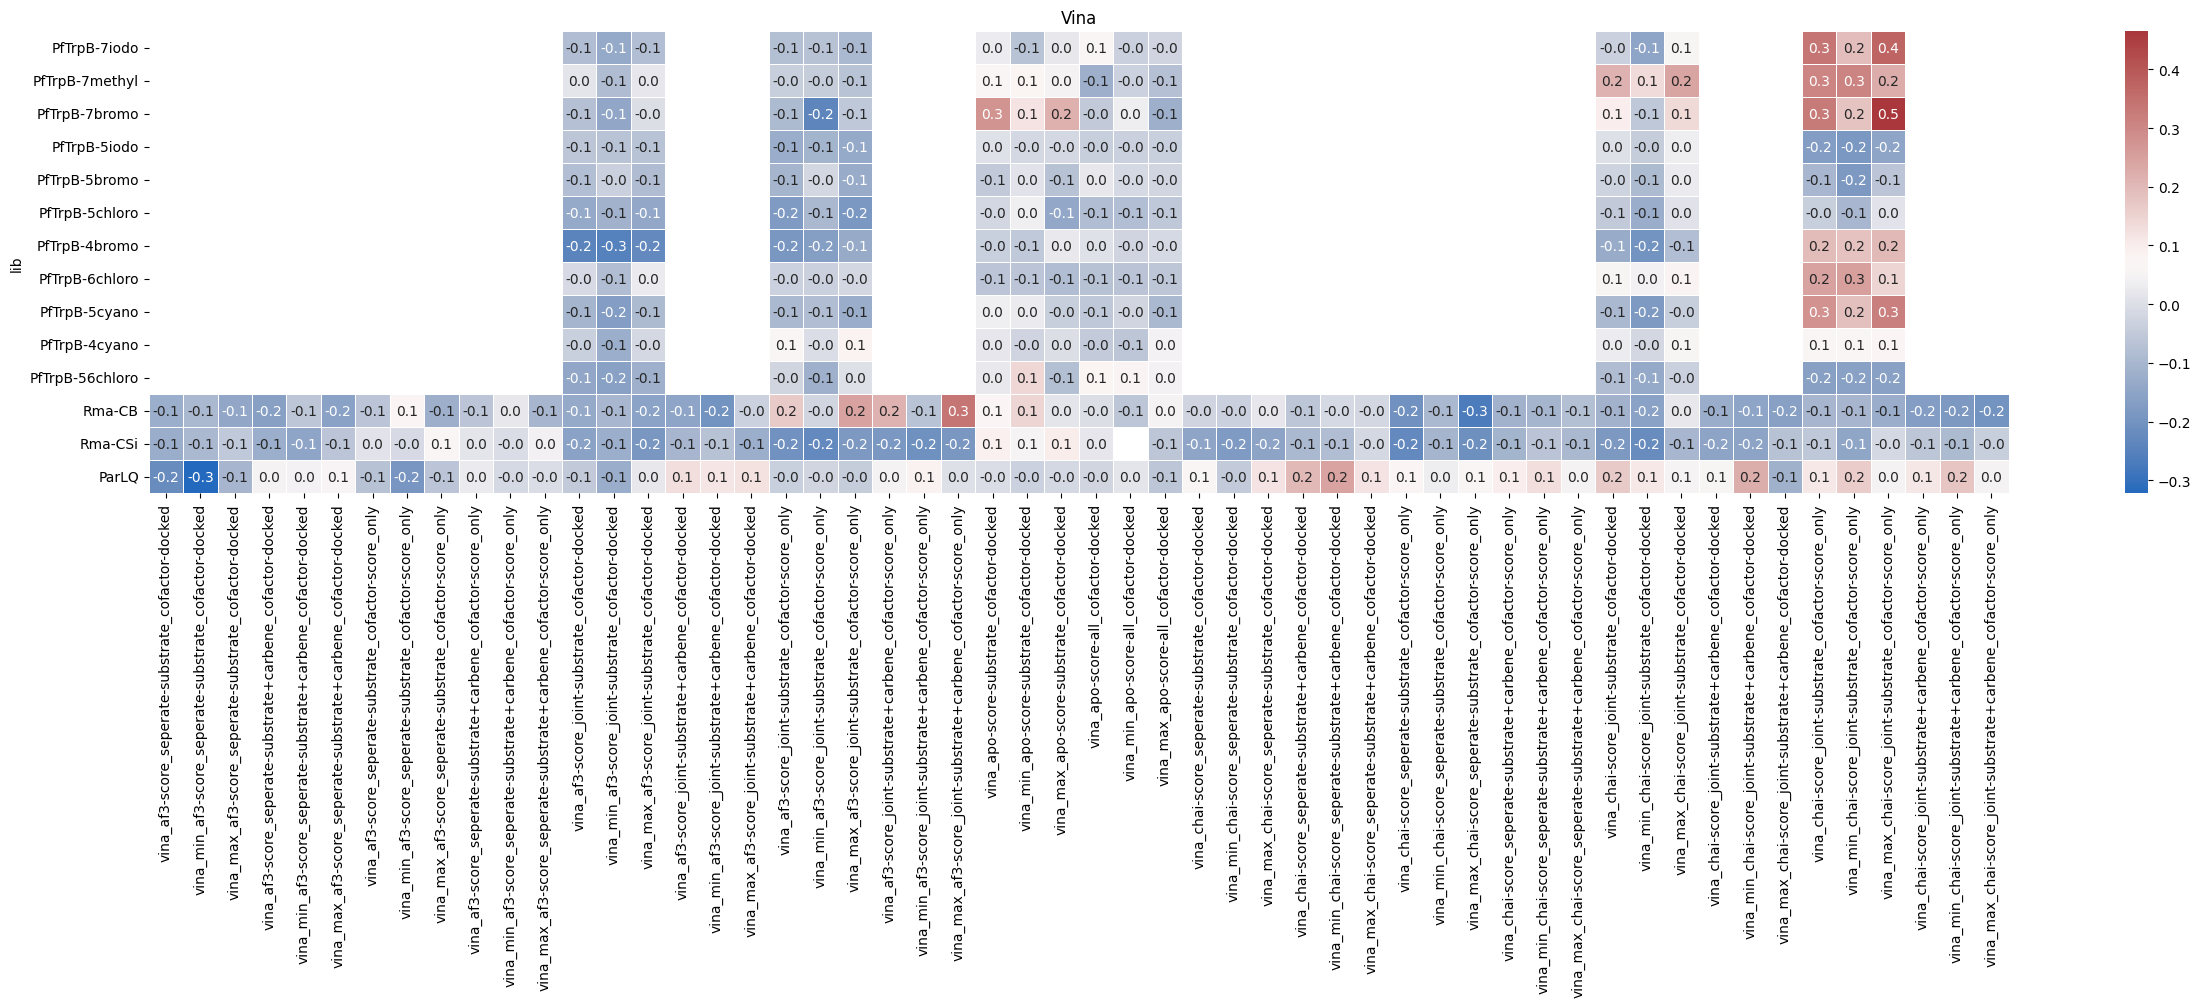

In [27]:
vina_cols = [
    "lib",
    "vina_af3-score_seperate-substrate_cofactor-docked",
    "vina_min_af3-score_seperate-substrate_cofactor-docked",
    "vina_max_af3-score_seperate-substrate_cofactor-docked",
    "vina_af3-score_seperate-substrate+carbene_cofactor-docked",
    "vina_min_af3-score_seperate-substrate+carbene_cofactor-docked",
    "vina_max_af3-score_seperate-substrate+carbene_cofactor-docked",
    "vina_af3-score_seperate-substrate_cofactor-score_only",
    "vina_min_af3-score_seperate-substrate_cofactor-score_only",
    "vina_max_af3-score_seperate-substrate_cofactor-score_only",
    "vina_af3-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_min_af3-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_max_af3-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_af3-score_joint-substrate_cofactor-docked",
    "vina_min_af3-score_joint-substrate_cofactor-docked",
    "vina_max_af3-score_joint-substrate_cofactor-docked",
    "vina_af3-score_joint-substrate+carbene_cofactor-docked",
    "vina_min_af3-score_joint-substrate+carbene_cofactor-docked",
    "vina_max_af3-score_joint-substrate+carbene_cofactor-docked",
    "vina_af3-score_joint-substrate_cofactor-score_only",
    "vina_min_af3-score_joint-substrate_cofactor-score_only",
    "vina_max_af3-score_joint-substrate_cofactor-score_only",
    "vina_af3-score_joint-substrate+carbene_cofactor-score_only",
    "vina_min_af3-score_joint-substrate+carbene_cofactor-score_only",
    "vina_max_af3-score_joint-substrate+carbene_cofactor-score_only",
    "vina_apo-score-substrate_cofactor-docked",
    "vina_min_apo-score-substrate_cofactor-docked",
    "vina_max_apo-score-substrate_cofactor-docked",
    "vina_apo-score-all_cofactor-docked",
    "vina_min_apo-score-all_cofactor-docked",
    "vina_max_apo-score-all_cofactor-docked",
    "vina_chai-score_seperate-substrate_cofactor-docked",
    "vina_min_chai-score_seperate-substrate_cofactor-docked",
    "vina_max_chai-score_seperate-substrate_cofactor-docked",
    "vina_chai-score_seperate-substrate+carbene_cofactor-docked",
    "vina_min_chai-score_seperate-substrate+carbene_cofactor-docked",
    "vina_max_chai-score_seperate-substrate+carbene_cofactor-docked",
    "vina_chai-score_seperate-substrate_cofactor-score_only",
    "vina_min_chai-score_seperate-substrate_cofactor-score_only",
    "vina_max_chai-score_seperate-substrate_cofactor-score_only",
    "vina_chai-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_min_chai-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_max_chai-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_chai-score_joint-substrate_cofactor-docked",
    "vina_min_chai-score_joint-substrate_cofactor-docked",
    "vina_max_chai-score_joint-substrate_cofactor-docked",
    "vina_chai-score_joint-substrate+carbene_cofactor-docked",
    "vina_min_chai-score_joint-substrate+carbene_cofactor-docked",
    "vina_max_chai-score_joint-substrate+carbene_cofactor-docked",
    "vina_chai-score_joint-substrate_cofactor-score_only",
    "vina_min_chai-score_joint-substrate_cofactor-score_only",
    "vina_max_chai-score_joint-substrate_cofactor-score_only",
    "vina_chai-score_joint-substrate+carbene_cofactor-score_only",
    "vina_min_chai-score_joint-substrate+carbene_cofactor-score_only",
    "vina_max_chai-score_joint-substrate+carbene_cofactor-score_only"
]
vina_df = df_rho_fit[vina_cols].set_index("lib").reindex(custom_order)

# Set the figure size
plt.figure(figsize=(30, 6))
# Create a heatmap
sns.heatmap(vina_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)
# Show the plot
plt.title("Vina")

In [28]:
vina_df.mean().sort_values(ascending=False)[:16]

vina_max_chai-score_joint-substrate_cofactor-score_only              0.096372
vina_chai-score_joint-substrate_cofactor-score_only                  0.088187
vina_max_af3-score_joint-substrate+carbene_cofactor-score_only       0.050933
vina_min_chai-score_seperate-substrate+carbene_cofactor-docked       0.049318
vina_min_chai-score_joint-substrate_cofactor-score_only              0.046765
vina_max_chai-score_joint-substrate_cofactor-docked                  0.032554
vina_apo-score-substrate_cofactor-docked                             0.031510
vina_max_chai-score_seperate-substrate+carbene_cofactor-docked       0.027470
vina_af3-score_joint-substrate+carbene_cofactor-score_only           0.025905
vina_min_apo-score-substrate_cofactor-docked                         0.024832
vina_chai-score_seperate-substrate+carbene_cofactor-docked           0.014973
vina_min_af3-score_seperate-substrate+carbene_cofactor-score_only    0.001151
vina_max_apo-score-substrate_cofactor-docked                    

Text(0.5, 1.0, 'Hydro')

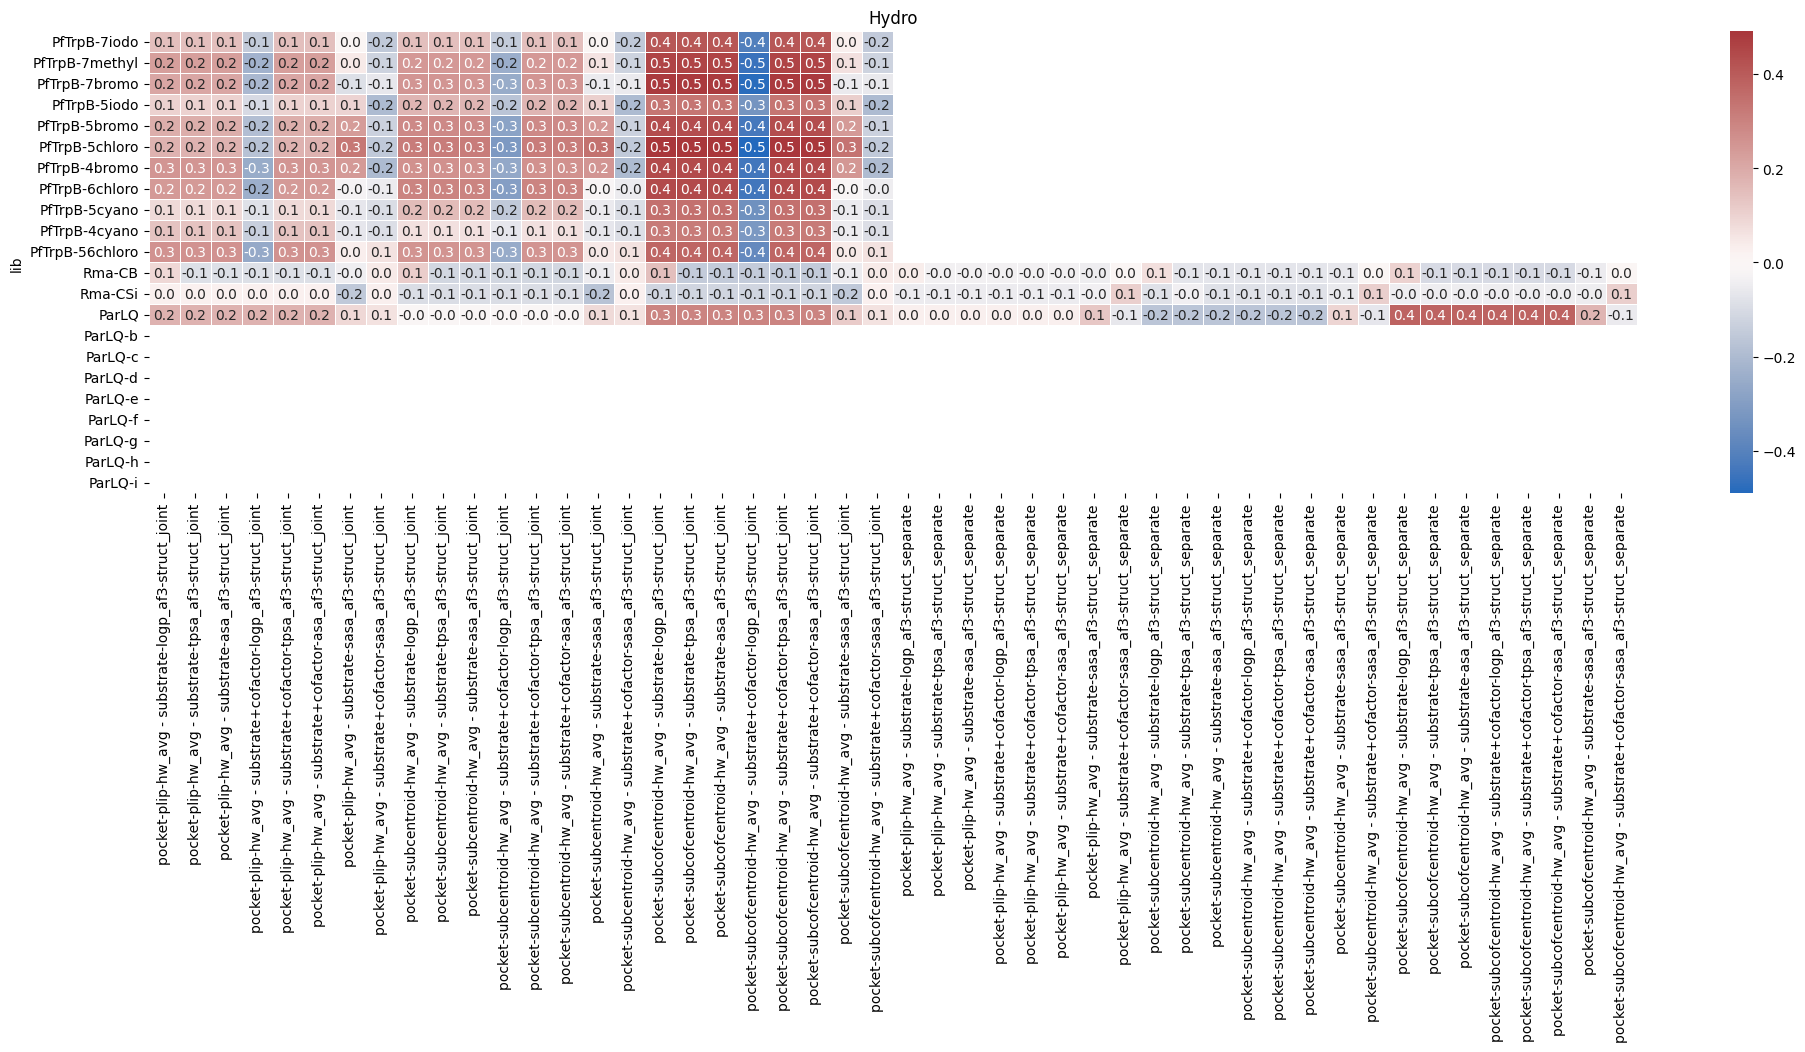

In [20]:
hydro_cols = [c for c in df_rho_fit.columns if " - " in c and "_avg" in c and "-hw" in c]
hydro_df = df_rho_fit[["lib"] + hydro_cols].set_index("lib").reindex(custom_order)

# Set the figure size
plt.figure(figsize=(24, 6))
# Create a heatmap
sns.heatmap(hydro_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)
# Show the plot
plt.title("Hydro")

In [51]:
hydro_df.mean().sort_values(ascending=False)[:20]

pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint                0.347928
pocket-subcofcentroid-hw_avg - substrate+cofactor-asa_af3-struct_joint        0.326645
pocket-subcofcentroid-hw_avg - substrate+cofactor-tpsa_af3-struct_joint       0.326645
pocket-subcofcentroid-hw_avg - substrate-asa_af3-struct_joint                 0.326645
pocket-subcofcentroid-hw_avg - substrate-tpsa_af3-struct_joint                0.326645
pocket-subcentroid-hw_avg - substrate-logp_af3-struct_joint                   0.175470
pocket-plip-hw_avg - substrate-logp_af3-struct_joint                          0.165057
pocket-subcentroid-hw_avg - substrate-asa_af3-struct_joint                    0.159489
pocket-subcentroid-hw_avg - substrate+cofactor-asa_af3-struct_joint           0.159489
pocket-subcentroid-hw_avg - substrate+cofactor-tpsa_af3-struct_joint          0.159489
pocket-subcentroid-hw_avg - substrate-tpsa_af3-struct_joint                   0.159466
pocket-plip-hw_avg - substrate+cofactor-asa

Text(0.5, 1.0, 'Rosetta')

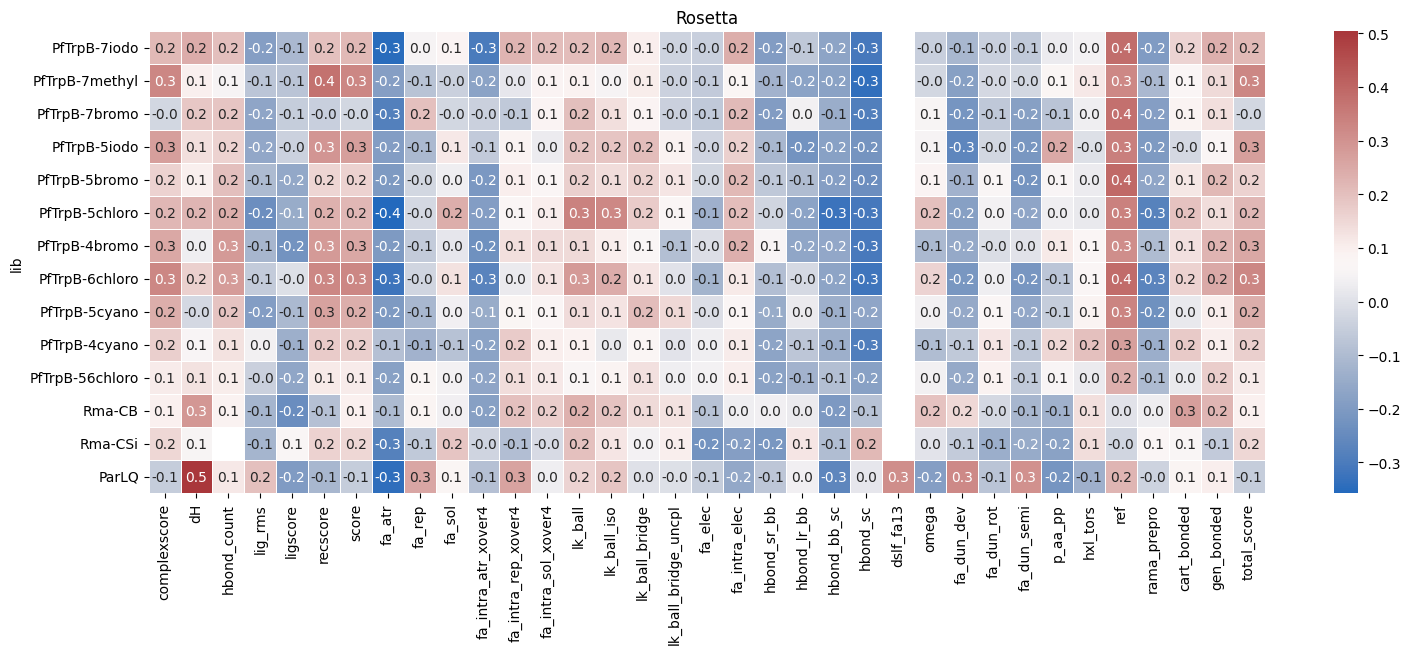

In [52]:
rosetta_cols = [
    "complexscore", "dH", "hbond_count", "lig_rms", "ligscore", 
     "recscore", "score", "fa_atr", "fa_rep", "fa_sol", 
    "fa_intra_atr_xover4", "fa_intra_rep_xover4", "fa_intra_sol_xover4", "lk_ball", 
    "lk_ball_iso", "lk_ball_bridge", "lk_ball_bridge_uncpl", "fa_elec", "fa_intra_elec", 
    "hbond_sr_bb", "hbond_lr_bb", "hbond_bb_sc", "hbond_sc", "dslf_fa13", "omega", 
    "fa_dun_dev", "fa_dun_rot", "fa_dun_semi", "p_aa_pp", "hxl_tors", "ref", 
    "rama_prepro", "cart_bonded", "gen_bonded", "total_score"
]

rosetta_df = df_rho_fit[["lib"] + rosetta_cols].set_index("lib").reindex(custom_order)

# Set the figure size
plt.figure(figsize=(18, 6))
# Create a heatmap
sns.heatmap(rosetta_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)
# Show the plot
plt.title("Rosetta")

In [53]:
rosetta_df.mean().sort_values(ascending=False)[:10]

dslf_fa13       0.310281
ref             0.279242
lk_ball         0.180072
complexscore    0.175951
score           0.175951
total_score     0.175946
hbond_count     0.172386
recscore        0.166874
dH              0.157106
lk_ball_iso     0.152592
dtype: float64

Text(0.5, 1.0, 'Vol')

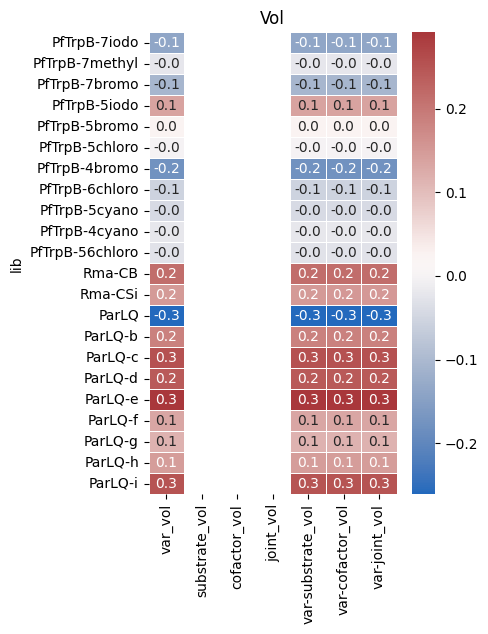

In [21]:
vol_cols = [c for c in df_rho_fit.columns if "_vol" in c]

vol_df = df_rho_fit[["lib"] + vol_cols].set_index("lib").reindex(custom_order)

# Set the figure size
plt.figure(figsize=(4, 6))
# Create a heatmap
sns.heatmap(vol_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)
# Show the plot
plt.title("Vol")

In [23]:
custom_order[-9:]

['ParLQ',
 'ParLQ-b',
 'ParLQ-c',
 'ParLQ-d',
 'ParLQ-e',
 'ParLQ-f',
 'ParLQ-g',
 'ParLQ-h',
 'ParLQ-i']

Text(0.5, 1.0, 'ZS Summary: Spearman correlation')

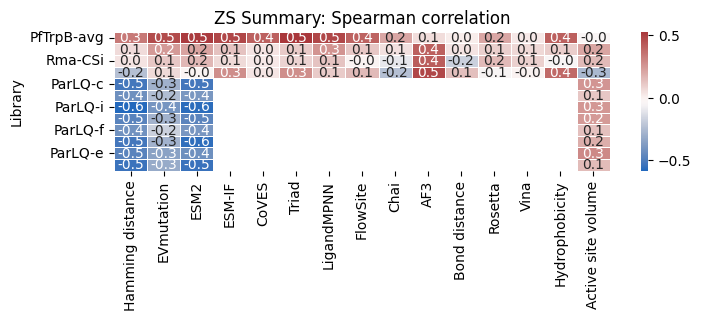

In [26]:
trpb_rho_df = df_rho_fit[df_rho_fit["lib"].isin(custom_order[:11])].copy()
trpb_rho_df = (
    trpb_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_AB_avg_score_joint_chai",
            "chain_iptm_AB_avg_score_joint_af3",
            "1:GLU-NH_1_avg_chai-struct_joint",
            # "1:GLU-NH_1_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "complexscore",
            "vina_apo-score-substrate_cofactor-docked",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_AB_avg_score_joint_chai": "Chai",
            "chain_iptm_AB_avg_score_joint_af3": "AF3",
            "1:GLU-NH_1_avg_chai-struct_joint": "Bond distance",
            # "1:GLU-NH_1_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "complexscore": "Rosetta",
            "vina_apo-score-substrate_cofactor-docked": "Vina",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint": "Hydrophobicity",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

# rename the lib to be PfTrpB
trpbmean = trpb_rho_df.set_index("Library").mean().to_frame().T
trpbmean["Library"] = "PfTrpB-avg"
trpbmean = trpbmean[["Library"] + trpbmean.columns.tolist()[:-1]].reset_index(drop=True)

parlq_rho_df = df_rho_fit[df_rho_fit["lib"].isin(custom_order[-9:])].copy()# df_rho_fit[df_rho_fit["lib"] == "ParLQ"].copy()
parlq_rho_df = (
    parlq_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            # "0:C-C_1_avg_chai-struct_seperate",
            "0:C-C_1_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "complexscore",
            "vina_apo-score-substrate_cofactor-docked",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3",
            # "0:C-C_1_avg_chai-struct_seperate": "Bond distance (Chai)",
            "0:C-C_1_avg_af3-struct_seperate": "Bond distance",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "complexscore": "Rosetta",
            "vina_apo-score-substrate_cofactor-docked": "Vina",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate": "Hydrophobicity",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

parlqmean = parlq_rho_df.set_index("Library").mean().to_frame().T
parlqmean["Library"] = "ParLQ-avg"
parlqmean = parlqmean[["Library"] + parlqmean.columns.tolist()[:-1]].reset_index(drop=True)

cb_df = df_rho_fit[df_rho_fit["lib"] == "Rma-CB"].copy()
cb_df = (
    cb_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            # "0:C-B_avg_chai-struct_joint",
            "0:C-B_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "complexscore",
            "vina_apo-score-substrate_cofactor-docked",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3",
            # "0:C-B_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-B_avg_af3-struct_seperate": "Bond distance",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "complexscore": "Rosetta",
            "vina_apo-score-substrate_cofactor-docked": "Vina",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate": "Hydrophobicity",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

csi_df = df_rho_fit[df_rho_fit["lib"] == "Rma-CSi"].copy()
csi_df = (
    csi_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            # "0:C-Si_avg_chai-struct_joint",
            "0:C-Si_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "complexscore",
            "vina_apo-score-substrate_cofactor-docked",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3",
            # "0:C-Si_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-Si_avg_af3-struct_seperate": "Bond distance",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "complexscore": "Rosetta",
            "vina_apo-score-substrate_cofactor-docked": "Vina",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate": "Hydrophobicity",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

# Set the figure size
plt.figure(figsize=(8, 1.8))
# Create a heatmap
sns.heatmap(
    pd.concat([trpbmean, cb_df, csi_df, parlqmean])[
        [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai",
            "AF3",
            "Bond distance",
            "Rosetta",
            "Vina",
            "Hydrophobicity",
            "Active site volume",
        ]
    ]
    .set_index("Library"),
    .reindex(["PfTrpB-avg", "Rma-CB", "Rma-CSi", "ParLQ"]),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title("ZS Summary: Spearman correlation")

In [25]:
parlq_rho_df

,Library,Hamming distance,EVmutation,ESM2,ESM-IF,CoVES,Triad,Chai,AF3,Bond distance,LigandMPNN,FlowSite,Rosetta,Vina,Hydrophobicity,Active site volume
0,ParLQ,-0.231575,0.064764,-0.016563,0.278441,0.035015,0.278514,-0.234002,0.478716,0.139871,0.102997,0.149739,-0.051786,-0.00307,0.383057,-0.261154
1,ParLQ-c,-0.523777,-0.288563,-0.523392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256508
2,ParLQ-g,-0.422985,-0.245213,-0.394363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.115883
3,ParLQ-i,-0.580458,-0.402492,-0.565194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250734
4,ParLQ-d,-0.473643,-0.285339,-0.471556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.242391
5,ParLQ-f,-0.413108,-0.174665,-0.395544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.133180
6,ParLQ-b,-0.520785,-0.282476,-0.559427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.187541
7,ParLQ-e,-0.475777,-0.348154,-0.422326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.291381
8,ParLQ-h,-0.538156,-0.314253,-0.541704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.145375


Text(0.5, 1.0, 'ZS Summary: Spearman correlation')

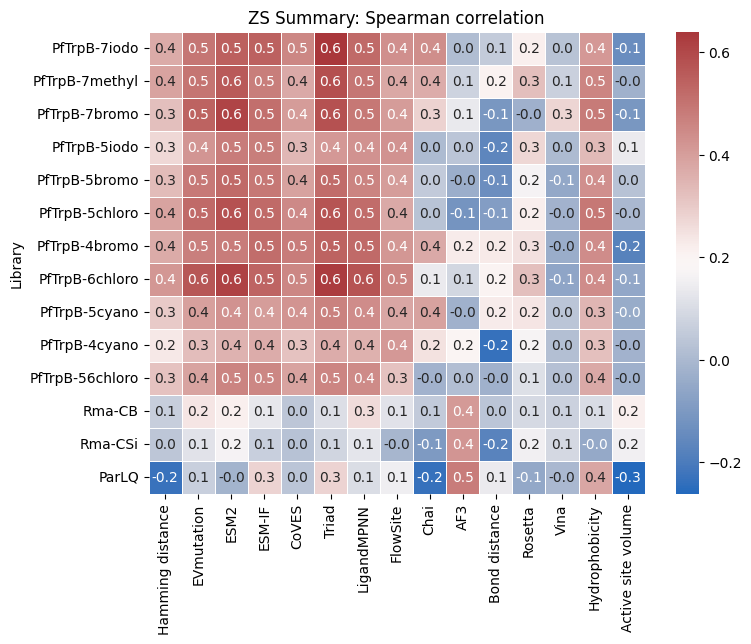

In [105]:
# Set the figure size
plt.figure(figsize=(8, 6))
# Create a heatmap
sns.heatmap(
    pd.concat([trpb_rho_df, cb_df, csi_df, parlq_rho_df])[
        [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai",
            "AF3",
            "Bond distance",
            "Rosetta",
            "Vina",
            "Hydrophobicity",
            "Active site volume",
        ]
    ]
    .set_index("Library")
    .reindex(custom_order),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title("ZS Summary: Spearman correlation")

In [73]:
df_rho_fit[df_rho_fit["lib"] == "ParLQ"]["pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate"]

0    0.383057
Name: pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate, dtype: float64

Text(0.5, 1.0, 'ZS Summary: Spearman correlation for selectivity')

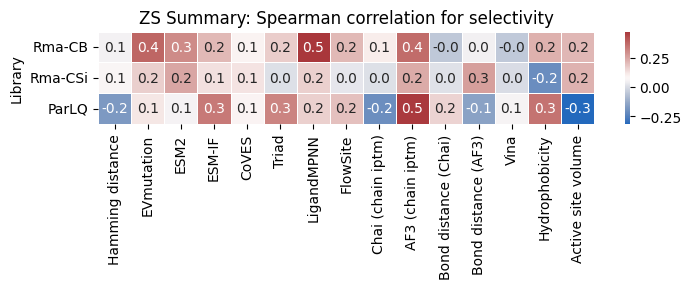

In [28]:

parlq_sele_df = df_rho_sele[df_rho_sele["lib"] == "ParLQ"].copy()
parlq_sele_df = (
    parlq_sele_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-C_1_avg_chai-struct_seperate",
            "0:C-C_1_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-C_1_avg_chai-struct_seperate": "Bond distance (Chai)",
            "0:C-C_1_avg_af3-struct_seperate": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint": "Hydrophobicity",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)


cb_df = df_rho_sele[df_rho_sele["lib"] == "Rma-CB"].copy()
cb_df = (
    cb_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-B_avg_chai-struct_joint",
            "0:C-B_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-B_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-B_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint": "Hydrophobicity",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

csi_df = df_rho_sele[df_rho_sele["lib"] == "Rma-CSi"].copy()
csi_df = (
    csi_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-Si_avg_chai-struct_joint",
            "0:C-Si_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-Si_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-Si_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint": "Hydrophobicity",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

# Set the figure size
plt.figure(figsize=(8, 1.2))
# Create a heatmap
sns.heatmap(
    pd.concat([parlq_sele_df, cb_df, csi_df])[
        [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai (chain iptm)",
            "AF3 (chain iptm)",
            "Bond distance (Chai)",
            "Bond distance (AF3)",
            "Vina",
            "Hydrophobicity",
            "Active site volume",
        ]
    ]
    .set_index("Library")
    .reindex(custom_order[-3:]),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title("ZS Summary: Spearman correlation for selectivity")

In [ ]:
trpb_rho_df = df_ndcg[df_ndcg["lib"].isin(custom_order[:11])].copy()
trpb_rho_df = (
    trpb_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_AB_avg_score_joint_chai",
            "chain_iptm_AB_avg_score_joint_af3",
            "1:GLU-NH_1_avg_chai-struct_joint",
            "1:GLU-NH_1_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_AB_avg_score_joint_chai": "Chai (chain iptm)",
            "chain_iptm_AB_avg_score_joint_af3": "AF3 (chain iptm)",
            "1:GLU-NH_1_avg_chai-struct_joint": "Bond distance (Chai)",
            "1:GLU-NH_1_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

parlq_rho_df = df_ndcg[df_ndcg["lib"] == "ParLQ"].copy()
parlq_rho_df = (
    parlq_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-C_1_avg_chai-struct_seperate",
            "0:C-C_1_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-C_1_avg_chai-struct_seperate": "Bond distance (Chai)",
            "0:C-C_1_avg_af3-struct_seperate": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)


cb_df = df_ndcg[df_ndcg["lib"] == "Rma-CB"].copy()
cb_df = (
    cb_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-B_avg_chai-struct_joint",
            "0:C-B_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-B_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-B_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

csi_df = df_ndcg[df_ndcg["lib"] == "Rma-CSi"].copy()
csi_df = (
    csi_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-Si_avg_chai-struct_joint",
            "0:C-Si_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-Si_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-Si_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

# Set the figure size
plt.figure(figsize=(8, 6))
# Create a heatmap
sns.heatmap(
    pd.concat([trpb_rho_df, parlq_rho_df, cb_df, csi_df])[
        [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai (chain iptm)",
            "AF3 (chain iptm)",
            "Bond distance (Chai)",
            "Bond distance (AF3)",
            "Vina",
            "Active site volume",
        ]
    ]
    .set_index("Library")
    .reindex(custom_order),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title("ZS Summary: NDCG")

In [ ]:
trpb_rho_df = df_top10_fit[df_top10_fit["lib"].isin(custom_order[:11])].copy()
trpb_rho_df = (
    trpb_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_AB_avg_score_joint_chai",
            "chain_iptm_AB_avg_score_joint_af3",
            "1:GLU-NH_1_avg_chai-struct_joint",
            "1:GLU-NH_1_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_AB_avg_score_joint_chai": "Chai (chain iptm)",
            "chain_iptm_AB_avg_score_joint_af3": "AF3 (chain iptm)",
            "1:GLU-NH_1_avg_chai-struct_joint": "Bond distance (Chai)",
            "1:GLU-NH_1_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

parlq_rho_df = df_top10_fit[df_top10_fit["lib"] == "ParLQ"].copy()
parlq_rho_df = (
    parlq_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-C_1_avg_chai-struct_seperate",
            "0:C-C_1_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-C_1_avg_chai-struct_seperate": "Bond distance (Chai)",
            "0:C-C_1_avg_af3-struct_seperate": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)


cb_df = df_top10_fit[df_top10_fit["lib"] == "Rma-CB"].copy()
cb_df = (
    cb_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-B_avg_chai-struct_joint",
            "0:C-B_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-B_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-B_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

csi_df = df_top10_fit[df_top10_fit["lib"] == "Rma-CSi"].copy()
csi_df = (
    csi_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-Si_avg_chai-struct_joint",
            "0:C-Si_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-Si_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-Si_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

# Set the figure size
plt.figure(figsize=(8, 6))
# Create a heatmap
sns.heatmap(
    pd.concat([trpb_rho_df, parlq_rho_df, cb_df, csi_df])[
        [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai (chain iptm)",
            "AF3 (chain iptm)",
            "Bond distance (Chai)",
            "Bond distance (AF3)",
            "Vina",
            "Active site volume",
        ]
    ]
    .set_index("Library")
    .reindex(custom_order),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title(r"ZS Summary: Top 10% recall")

In [ ]:
trpb_rho_df = df_top25_fit[df_top25_fit["lib"].isin(custom_order[:11])].copy()
trpb_rho_df = (
    trpb_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_AB_avg_score_joint_chai",
            "chain_iptm_AB_avg_score_joint_af3",
            "1:GLU-NH_1_avg_chai-struct_joint",
            "1:GLU-NH_1_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_AB_avg_score_joint_chai": "Chai (chain iptm)",
            "chain_iptm_AB_avg_score_joint_af3": "AF3 (chain iptm)",
            "1:GLU-NH_1_avg_chai-struct_joint": "Bond distance (Chai)",
            "1:GLU-NH_1_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

parlq_rho_df = df_top25_fit[df_top25_fit["lib"] == "ParLQ"].copy()
parlq_rho_df = (
    parlq_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-C_1_avg_chai-struct_seperate",
            "0:C-C_1_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-C_1_avg_chai-struct_seperate": "Bond distance (Chai)",
            "0:C-C_1_avg_af3-struct_seperate": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)


cb_df = df_top25_fit[df_top25_fit["lib"] == "Rma-CB"].copy()
cb_df = (
    cb_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-B_avg_chai-struct_joint",
            "0:C-B_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-B_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-B_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

csi_df = df_top25_fit[df_top25_fit["lib"] == "Rma-CSi"].copy()
csi_df = (
    csi_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-Si_avg_chai-struct_joint",
            "0:C-Si_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-Si_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-Si_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

# Set the figure size
plt.figure(figsize=(8, 6))
# Create a heatmap
sns.heatmap(
    pd.concat([trpb_rho_df, parlq_rho_df, cb_df, csi_df])[
        [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai (chain iptm)",
            "AF3 (chain iptm)",
            "Bond distance (Chai)",
            "Bond distance (AF3)",
            "Vina",
            "Active site volume",
        ]
    ]
    .set_index("Library")
    .reindex(custom_order),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title(r"ZS Summary: Top 25% recall")

In [ ]:
trpb_rho_df = df_top50_fit[df_top50_fit["lib"].isin(custom_order[:11])].copy()
trpb_rho_df = (
    trpb_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_AB_avg_score_joint_chai",
            "chain_iptm_AB_avg_score_joint_af3",
            "1:GLU-NH_1_avg_chai-struct_joint",
            "1:GLU-NH_1_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_AB_avg_score_joint_chai": "Chai (chain iptm)",
            "chain_iptm_AB_avg_score_joint_af3": "AF3 (chain iptm)",
            "1:GLU-NH_1_avg_chai-struct_joint": "Bond distance (Chai)",
            "1:GLU-NH_1_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

parlq_rho_df = df_top50_fit[df_top50_fit["lib"] == "ParLQ"].copy()
parlq_rho_df = (
    parlq_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-C_1_avg_chai-struct_seperate",
            "0:C-C_1_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-C_1_avg_chai-struct_seperate": "Bond distance (Chai)",
            "0:C-C_1_avg_af3-struct_seperate": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)


cb_df = df_top50_fit[df_top50_fit["lib"] == "Rma-CB"].copy()
cb_df = (
    cb_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-B_avg_chai-struct_joint",
            "0:C-B_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-B_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-B_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

csi_df = df_top50_fit[df_top50_fit["lib"] == "Rma-CSi"].copy()
csi_df = (
    csi_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            "0:C-Si_avg_chai-struct_joint",
            "0:C-Si_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "vina_min_apo-score-substrate_cofactor-docked",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai (chain iptm)",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3 (chain iptm)",
            "0:C-Si_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-Si_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "vina_min_apo-score-substrate_cofactor-docked": "Vina",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

# Set the figure size
plt.figure(figsize=(8, 6))
# Create a heatmap
sns.heatmap(
    pd.concat([trpb_rho_df, parlq_rho_df, cb_df, csi_df])[
        [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai (chain iptm)",
            "AF3 (chain iptm)",
            "Bond distance (Chai)",
            "Bond distance (AF3)",
            "Vina",
            "Active site volume",
        ]
    ]
    .set_index("Library")
    .reindex(custom_order),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title(r"ZS Summary: Top 50% recall")

In [ ]:
for c in df_rho_fit.columns:
    if " - " in c and "avg" in c:
        print(c)